Import libraries

In [213]:
import pandas as pd
import numpy as np
import talib
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt

Fetch Historical data for the AAPL stock

In [214]:
# Fetch data for a specific stock
ticker = "META"
stock_data = yf.download(ticker, start="2020-01-01", end="2025-01-01")
stock_data.reset_index(inplace=True)

# Inspect the data
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed

Price        Date       Close        High         Low        Open    Volume
Ticker                   META        META        META        META      META
0      2020-01-02  208.981705  208.991661  205.485067  205.963236  12077100
1      2020-01-03  207.875916  209.599328  206.162460  206.421480  11188400
2      2020-01-06  211.790985  211.970293  205.734120  205.913428  17058900
3      2020-01-07  212.249222  213.763442  210.944209  212.010145  14912400
4      2020-01-08  214.401001  215.417124  211.800932  212.189448  13475000


Get RSI

In [215]:
# Fill missing values in the 'Close' column first
stock_data['Close'] = stock_data['Close'].fillna(method='ffill')  # Forward-fill missing values
stock_data['Close'] = stock_data['Close'].fillna(method='bfill')  # Backward-fill if forward-fill is insufficient

# Calculate RSI after filling 'Close'
stock_data['RSI'] = talib.RSI(stock_data['Close'].values.flatten(), timeperiod=14)

# Fill the first 14 rows of RSI with the 15th row value
first_valid_rsi = stock_data.loc[14, 'RSI']  # Get the RSI value from the 15th row
stock_data.loc[:13, 'RSI'] = first_valid_rsi  # Fill the first 14 rows with this value

# Print the RSI column to verify
print(stock_data['RSI'].iloc[14])
stock_data.loc[:13, 'RSI'] = stock_data['RSI'].iloc[14]

print(stock_data['RSI'])

71.56429506638477
0       71.564295
1       71.564295
2       71.564295
3       71.564295
4       71.564295
          ...    
1253    54.160476
1254    52.117263
1255    50.467678
1256    46.620558
1257    44.194785
Name: RSI, Length: 1258, dtype: object


/var/folders/hv/2vlnl85n369fmvwhjtsktpsh0000gn/T/ipykernel_10063/3407466581.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data['Close'] = stock_data['Close'].fillna(method='ffill')  # Forward-fill missing values
/var/folders/hv/2vlnl85n369fmvwhjtsktpsh0000gn/T/ipykernel_10063/3407466581.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data['Close'] = stock_data['Close'].fillna(method='bfill')  # Backward-fill if forward-fill is insufficient
/var/folders/hv/2vlnl85n369fmvwhjtsktpsh0000gn/T/ipykernel_10063/3407466581.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dty

Get SMA

In [216]:
stock_data['SMA50'] = talib.SMA(stock_data['Close'].values.flatten(), timeperiod=50)
stock_data['SMA20'] = talib.SMA(stock_data['Close'].values.flatten(), timeperiod=20)

print(stock_data['SMA50'])
print(stock_data['SMA50'].shape)

print(stock_data['SMA20'])
print(stock_data['SMA20'].shape)

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
1253    586.118053
1254    586.469103
1255    586.938801
1256    587.234301
1257    587.424393
Name: SMA50, Length: 1258, dtype: float64
(1258,)
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
1253    605.483176
1254    606.996790
1255    608.550226
1256    609.419370
1257    609.077258
Name: SMA20, Length: 1258, dtype: float64
(1258,)


Find the Bollinger Band (BB Indicator)

In [217]:
stock_data['UpperBB'], stock_data['MiddleBB'], stock_data['LowerBB'] = talib.BBANDS(
    stock_data['Close'].values.flatten(), timeperiod=20
)


# Ensure there are no NaN for UpperBB
stock_data.loc[0:20, 'UpperBB'] = stock_data['UpperBB'].iloc[19]
print(stock_data['UpperBB'])


# Ensure there are no NanN for LowerBB
stock_data.loc[0:20, 'LowerBB'] = stock_data['LowerBB'].iloc[19]
print(stock_data['LowerBB'])


# Ensure there are no NanN for MiddleBB
stock_data.loc[0:20, 'MiddleBB'] = stock_data['MiddleBB'].iloc[19]
print(stock_data['MiddleBB'])



0       225.472971
1       225.472971
2       225.472971
3       225.472971
4       225.472971
           ...    
1253    642.756394
1254    641.216898
1255    638.198096
1256    635.785656
1257    636.477750
Name: UpperBB, Length: 1258, dtype: float64
0       207.632595
1       207.632595
2       207.632595
3       207.632595
4       207.632595
           ...    
1253    568.209957
1254    572.776682
1255    578.902356
1256    583.053083
1257    581.676766
Name: LowerBB, Length: 1258, dtype: float64
0       216.552783
1       216.552783
2       216.552783
3       216.552783
4       216.552783
           ...    
1253    605.483176
1254    606.996790
1255    608.550226
1256    609.419370
1257    609.077258
Name: MiddleBB, Length: 1258, dtype: float64


Create a trading strategy with BB, SMA, and RSI and create buy or sell signals.

In [218]:
print(stock_data[['RSI', 'Close', 'LowerBB', 'UpperBB']].info())
print(stock_data.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (RSI, )        1258 non-null   object 
 1   (Close, META)  1258 non-null   float64
 2   (LowerBB, )    1258 non-null   float64
 3   (UpperBB, )    1258 non-null   float64
dtypes: float64(3), object(1)
memory usage: 39.4+ KB
None
MultiIndex([(    'Date',     ''),
            (   'Close', 'META'),
            (    'High', 'META'),
            (     'Low', 'META'),
            (    'Open', 'META'),
            (  'Volume', 'META'),
            (     'RSI',     ''),
            (   'SMA50',     ''),
            (   'SMA20',     ''),
            ( 'UpperBB',     ''),
            ('MiddleBB',     ''),
            ( 'LowerBB',     '')],
           names=['Price', 'Ticker'])


In [219]:
# Flatten the MultiIndex
stock_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in stock_data.columns]

# Verify the flattened column names
print(stock_data.columns)

# Initialize Signal column
stock_data['Signal'] = 0  # Default to no action

# Generate Buy and Sell Signals
stock_data.loc[
    (stock_data['RSI_'] < 30) & (stock_data[f'Close_{ticker}'] < stock_data['LowerBB_']),
    'Signal'
] = 1  # Buy signal

stock_data.loc[
    (stock_data['RSI_'] > 70) & (stock_data[f'Close_{ticker}'] > stock_data['UpperBB_']),
    'Signal'
] = -1  # Sell signal

# Verify the result
print(stock_data[['Date_', f'Close_{ticker}', 'RSI_', 'Signal']])

# Filter rows where Signal is 1 or -1
filtered_data = stock_data[(stock_data['Signal'] == 1) | (stock_data['Signal'] == -1)]

# Print the filtered rows
print(filtered_data)

Index(['Date_', 'Close_META', 'High_META', 'Low_META', 'Open_META',
       'Volume_META', 'RSI_', 'SMA50_', 'SMA20_', 'UpperBB_', 'MiddleBB_',
       'LowerBB_'],
      dtype='object')
          Date_  Close_META       RSI_  Signal
0    2020-01-02  208.981705  71.564295       0
1    2020-01-03  207.875916  71.564295       0
2    2020-01-06  211.790985  71.564295       0
3    2020-01-07  212.249222  71.564295       0
4    2020-01-08  214.401001  71.564295       0
...         ...         ...        ...     ...
1253 2024-12-24  607.750000  54.160476       0
1254 2024-12-26  603.349976  52.117263       0
1255 2024-12-27  599.809998  50.467678       0
1256 2024-12-30  591.239990  46.620558       0
1257 2024-12-31  585.510010  44.194785       0

[1258 rows x 4 columns]
          Date_  Close_META   High_META    Low_META   Open_META  Volume_META  \
38   2020-02-27  189.027924  195.134601  188.778875  191.090054     21682600   
45   2020-03-09  168.854980  174.334051  164.561384  168.954606   

Plot the signals

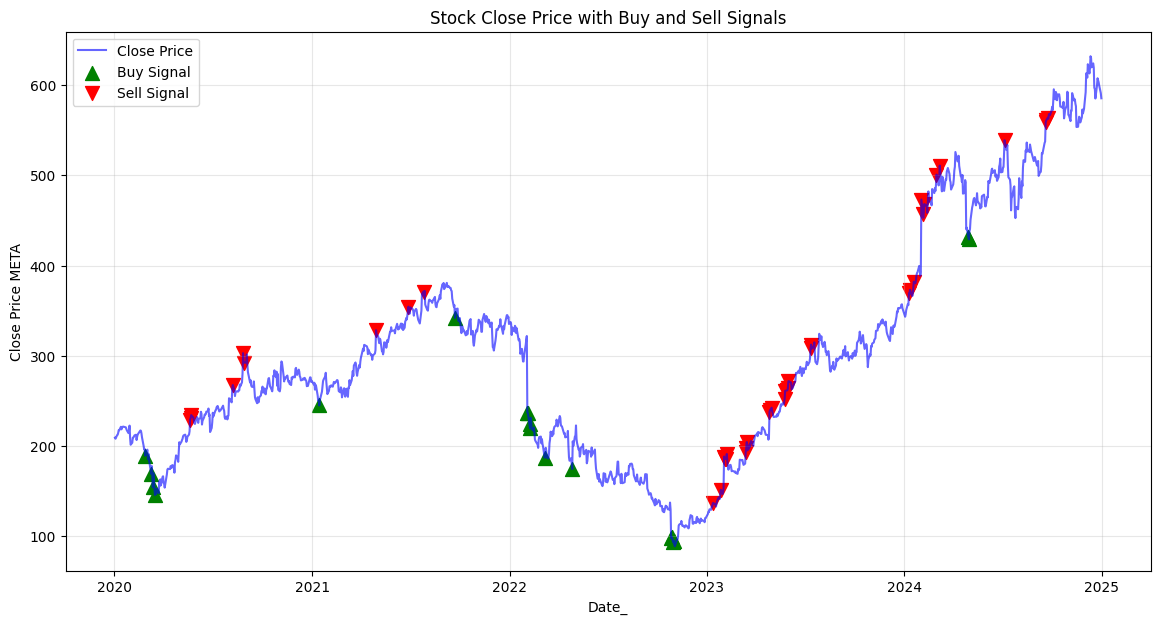

In [221]:
import matplotlib.pyplot as plt

# Filter rows with buy and sell signals
buy_signals = stock_data[stock_data['Signal'] == 1]
sell_signals = stock_data[stock_data['Signal'] == -1]

# Plot the stock's Close price
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Date_'], stock_data[f'Close_{ticker}'], label='Close Price', color='blue', alpha=0.6)

# Add buy signals to the plot
plt.scatter(buy_signals['Date_'], buy_signals[f'Close_{ticker}'], label='Buy Signal', marker='^', color='green', s=100)

# Add sell signals to the plot
plt.scatter(sell_signals['Date_'], sell_signals[f'Close_{ticker}'], label='Sell Signal', marker='v', color='red', s=100)

# Plot enhancements
plt.title('Stock Close Price with Buy and Sell Signals')
plt.xlabel('Date_')
plt.ylabel(f'Close Price {ticker}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()